Inicialización del programa. 26-29 Junio

In [37]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import triangle
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Properties of the planet candidate and its host star.

In [38]:
#Properties of Planet Candidate (Data taken from Spreadsheet)
depth = 0.15*0.01 # (In absolute terms)
period = 19.306566 # (In days)
ecc = 0.0
b = 0.5

t0 = 1919.57971 # (-2454900) 
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553

# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

Upload the photometric data and plot the raw LC.

In [39]:
import glob, os
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC
    #plt.figure(1)
    #plt.plot(timeLC[goodP], fluxLC[goodP],'.')
    #plt.xlabel('BJD-2454900', fontsize=12)
    #plt.ylabel('Flux', fontsize=12)
    #plt.title('Raw Light Curve',fontsize=12)

In [40]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
        
minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

[ 1919.57971   1938.886276  1958.192842  1977.499408]


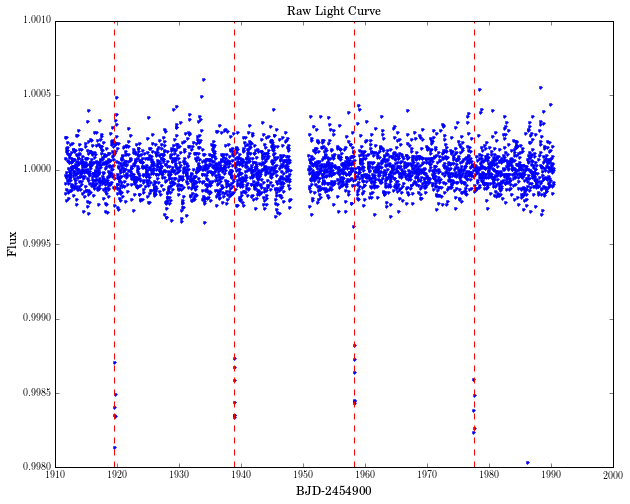

In [41]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.title('Raw Light Curve',fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

Select the points that are "transit_window" hours to the left and to the right of the transit.

In [42]:
t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

#print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

Plot the folded light curve.

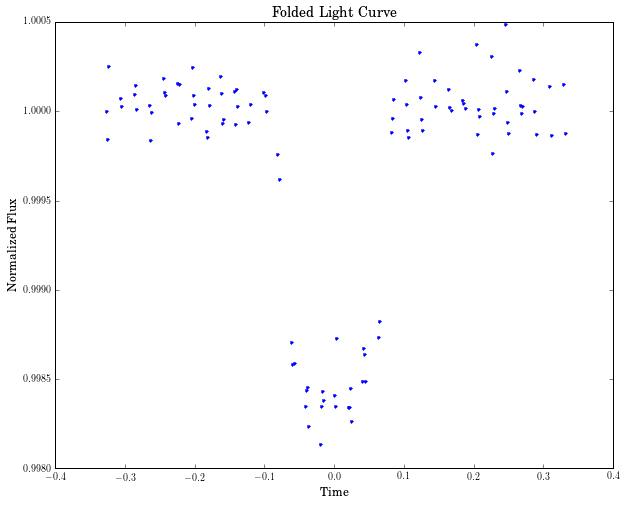

In [43]:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Folded Light Curve', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)

From the figure above, we visually estimate that the transit occurs within a range of "rangeTransit." In this case, it's roughly +-0.1.

In [44]:
rangeTransit = 0.1
dataBool = np.abs(dt)>=rangeTransit # If true, point is outside of the transit.
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # This is a boolean array that tells you which points are outside of the transit.

The next window allows you to plot each transit.

Fit the regions outside each transit.

In [45]:
#plt.figure(4)
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    #plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    #plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    #plt.plot(dt[transitBool],p(dt[transitBool]),'.')
    #plt.xlabel('Time',fontsize=9)
    #plt.ylabel('Flux',fontsize=10)
    #plt.title('Transit %d' % (i+1)) 
#plt.savefig("FitOutsideTransits.png")

Divide the "light curve" of each transit by the fit obtained in the previous window.

In [46]:
#plt.figure(5)
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    #plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    #plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    #plt.plot(dt[transitBool],fluxTrans[transitBool]/p(dt[transitBool]),'.')
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    #plt.show()
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

#Transit Analysis

We will assume that the flux of the star varies over time. Note that the variable dfdt_ml was not present in the previous version of this code (LCAnalysis_4).

In [47]:
dfdtGuess = []

for i in range (len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    k = np.polyfit(timeTrans[outsideBool],corFlux[outsideBool],1)
    dfdt = k[0]
    dfdtGuess.append(dfdt)

dfdt_ml = np.array(dfdtGuess)
print dfdt_ml

[ -4.71640748e-09  -3.04965471e-10   3.61848658e-09  -4.18133533e-10]


The following parameters are the best estimates obtained from the code "LCAnalysis_1." also available on Github.

In [48]:
depth_ml = 0.0015669276217474255
b_ml = 0.62688198679744078
sigma_ml = 4.0382821939991208e-11
sumLD_ml = 0.62054242543638494
mass_ml = 0.92718951248481241 #Best guess for mass of the star
radius_ml = 0.94091569399602548 #Best guess for radius of the star

# We will keep all the variables fixed except for the transit time.
allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, 
            sumLD_ml, mass_ml, radius_ml]

Calculates the log of the likelihood of the transit model being the right model with the transit time, the flux outside transit, and df/dt as our free parameters (pt0_i, f0_i, dfdt_i). The index i represents the transit being analyzed. Note: theta[0] = pt0_i, theta[1]=f0_i, theta[2]=dfdt_i

In [49]:
import transit
def lnlike(theta, numTrans, timeLC, fluxLC, errorLC, allfixed):
    pt0_i, f0_i, dfdt_i = theta
    period, ecc,mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml = allfixed 
    
    u1 = 0.5*(sumLD_ml+diffLD) 
    u2 = sumLD_ml-u1
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=mass_ml,radius=radius_ml))
    body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=pt0_i, b=np.abs(b_ml), e=ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma_ml**2)
    
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)  
    ftheo = ftheo-1+f0_i+ dfdt_i*(timeLC-pt0_i) 
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((mass_ml-mass)/masserr)**2
            + ((radius_ml-radius)/radiuserr)**2)

In [50]:
def optim (transitNum, timeLC, fluxLC, errorLC, allfixed):
    n3 = lambda *args: -lnlike(*args)
    result = op.minimize(n3,[transits[transitNum], 1.0, dfdt_ml[transitNum]], args=(transitNum, t_i, corFlux_i, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
    t0_fit, f0_fit, dfdt_fit = result["x"]
    return (t0_fit, f0_fit, dfdt_fit)

In [51]:
corFlux=fluxTrans 
t0fit=[]
f0fit=[]
dfdtfit=[]
for i in range(len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

    dt_i=dt[transitBool] # timeTrans-midTrans for transit i
    t_i=timeTrans[transitBool] # timeTrans for transit i
    corFlux_i=corFlux[transitBool] #corrected flux for transit i.
    
    aux1, aux2, aux3 = optim(i, t_i, corFlux_i, errorLC, allfixed)
    t0fit.append(aux1)
    f0fit.append(aux2)
    dfdtfit.append(aux3)

Optimization terminated successfully.
         Current function value: -245.982140
         Iterations: 43
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -247.048546
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -206.161822
         Iterations: 81
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -174.407080
         Iterations: 43
         Function evaluations: 111


The best estimates for the transit times of the raw LC (t0), the out-of-transit fluxes (f0), and df/dt's are given, respectively, by the lists "t0fit," "f0fit," and "dfdtfit."

In [52]:
print "Transit time estimates", np.array(t0fit)
print "Estimates for the flux outside the transit", np.array(f0fit)
print "dF/dt estimates for each transit", np.array(dfdtfit)

Transit time estimates [ 1919.57836719  1938.8838472   1958.19093499  1977.49637288]
Estimates for the flux outside the transit [ 0.99999998  1.00000004  1.00004094  1.00000005]
dF/dt estimates for each transit [ -4.71662350e-09  -3.04976084e-10   3.78570950e-09  -4.18171271e-10]


Compute each transit LC integrated over a Kepler long cadence exposure time with the result derived from optimization. Then, plot it.

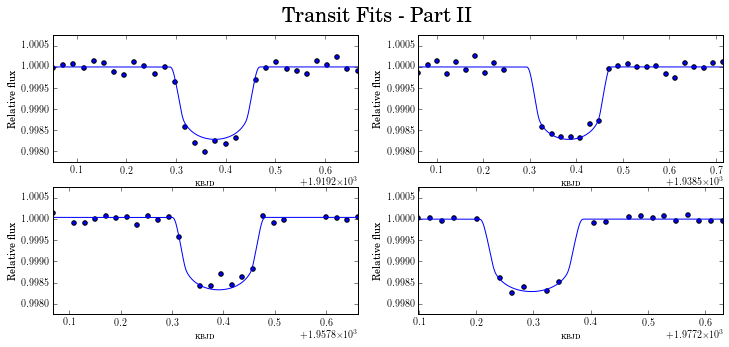

In [53]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Transit Fits - Part II', fontsize=20)

for i in range(len(transits)):
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass_ml, radius = radius_ml))
    body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0fit[i], b=np.abs(b_ml), e=ecc)
    s.add_body(body)

    t_theory = np.arange(-1, 1, tKep*0.01) + t0fit[i] # KBJD (Reduced BJD, i.e. BJD-2454900)
    f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
    
    
    f_theory = (f_theory-1.0+f0fit[i])+dfdt_ml[i]*(t_theory-t0fit[i])
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(timeTrans[flag==i],corFlux[flag==i])
    plt.xlim([min(timeTrans[flag==i]), max(timeTrans[flag==i])]) 
    plt.ylim([1-depth*1.5, depth*0.5+1]) 
    ax.set_xlabel('KBJD', fontsize=7)
    ax.set_ylabel('Relative flux', fontsize=10)
    ax.plot(t_theory, f_theory)
    
plt.savefig('transitFits_5.png')

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

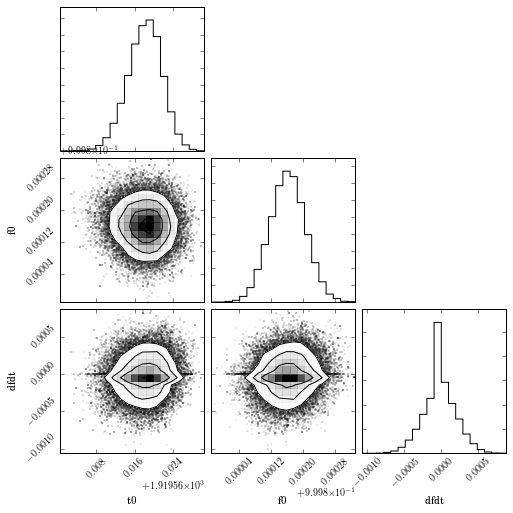

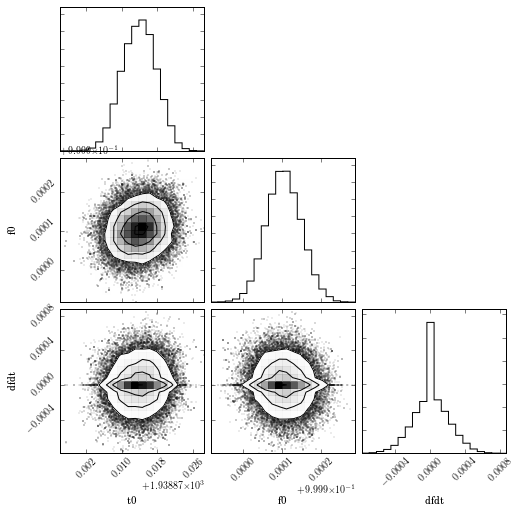

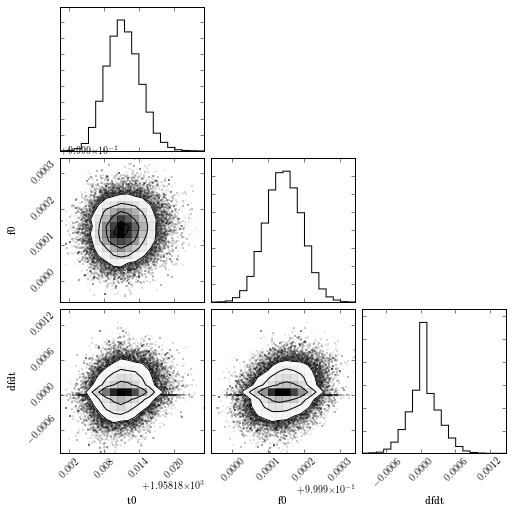

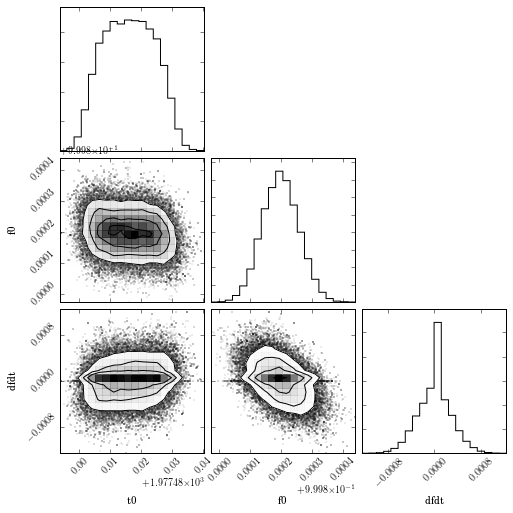

In [54]:
ndim, nwalkers = 3, 100 # 3 dimensions because we're fitting 3 parameters.
steps = 1000

t0fit_mcmc=np.zeros((len(transits),3)) 
f0fit_mcmc=np.zeros((len(transits),3))
dfdtfit_mcmc=np.zeros((len(transits),3))

'''
    Each row corresponds to a specific transit (row 1 = transit 1, etc.). 
    Column 1 = Best estimate.
    Column 2 = Upper error.
    Column 3 = Lower error
'''

fig = plt.figure(7)
for i in range(len(transits)):
    pos = [[t0fit[i], f0fit[i], dfdtfit[i]]*(1+1e-5*np.random.randn(ndim)) for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(i, timeTrans[flag==i], corFlux[flag==i], errorLC, allfixed))
    sampler.run_mcmc(pos, steps)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    fig = triangle.corner(samples, labels=["t0","f0","dfdt"])
    
    v1 = np.percentile(samples[:,0], [15.84, 50, 84.16], axis=0)
    t0fit_mcmc[i,0] = v1[1] # 3rd value is the best estimate for t0 (it falls at the center)
    t0fit_mcmc[i,1] = v1[2]-v1[1] #+ Error of t0
    t0fit_mcmc[i,2] = v1[1]-v1[0] #- Error of t0
 
    v2 = np.percentile(samples[:,1], [15.84, 50, 84.16], axis=0)
    f0fit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for f0
    f0fit_mcmc[i,1] = v2[2]-v2[1] #+ Error of f0
    f0fit_mcmc[i,2] = v2[1]-v2[0] #- Error of f0
    
    v3 = np.percentile(samples[:,2],[15.84, 50, 84.16], axis=0)
    dfdtfit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for df/dt
    dfdtfit_mcmc[i,1] = v2[2]-v2[1] #+ Error of df/dt
    dfdtfit_mcmc[i,2] = v2[1]-v2[0] #- Error of df/dt
    
    name = 'PartII_triangles %d' % (i+1)
    plt.savefig(name)

In [55]:
print t0fit_mcmc
print f0fit_mcmc
print dfdtfit_mcmc

[[  1.91957828e+03   3.34143531e-03   3.73354623e-03]
 [  1.93888402e+03   3.81416932e-03   3.99924666e-03]
 [  1.95819121e+03   2.99753190e-03   2.80942650e-03]
 [  1.97749620e+03   8.87603691e-03   8.83959686e-03]]
[[  9.99961963e-01   4.43383785e-05   4.48605715e-05]
 [  1.00000469e+00   4.60306983e-05   4.46036459e-05]
 [  1.00004252e+00   5.09176843e-05   5.08897536e-05]
 [  9.99997438e-01   6.02715005e-05   5.90533087e-05]]
[[  9.99961963e-01   4.43383785e-05   4.48605715e-05]
 [  1.00000469e+00   4.60306983e-05   4.46036459e-05]
 [  1.00004252e+00   5.09176843e-05   5.08897536e-05]
 [  9.99997438e-01   6.02715005e-05   5.90533087e-05]]


In [56]:
np.savetxt('PartII_t0mcmc.txt', t0fit_mcmc, fmt='%1.3f', delimiter='   ',
            header = """Transit time estimates (t0). The 1st column represents the 50% percentile of the MCMC posterior 
            distribution. The 2nd and 3rd show respectively the +1 and -1 sigma uncertainty. Each row is a transit 
            in the light curve (i.e. row 1 = transit 1, row 2 = transit 2, etc.).""") 

np.savetxt('PartII_f0mcmc.txt', f0fit_mcmc, fmt='%1.3f', delimiter='   ',
            header = """Outside-of-transit flux estimates (f0). The 1st column represents the 50% percentile of the MCMC posterior 
            distribution. The 2nd and 3rd show respectively the +1 and -1 sigma uncertainty. Each row is a transit 
            in the light curve (i.e. row 1 = transit 1, row 2 = transit 2, etc.).""") 

In [57]:
n = []
tobs = []
tobsErr = []
for i in range (len(transits)):
    aux = t0fit_mcmc[i,0]
    auxerr = (t0fit_mcmc[i,1] + t0fit_mcmc[i,2])/2
    n.append(i)
    tobs.append(aux)
    tobsErr.append(auxerr)

Optimal parameters: [   19.30636874  1919.57815877]
Uncertainties of parameters: [ 0.00030729  0.00047259]


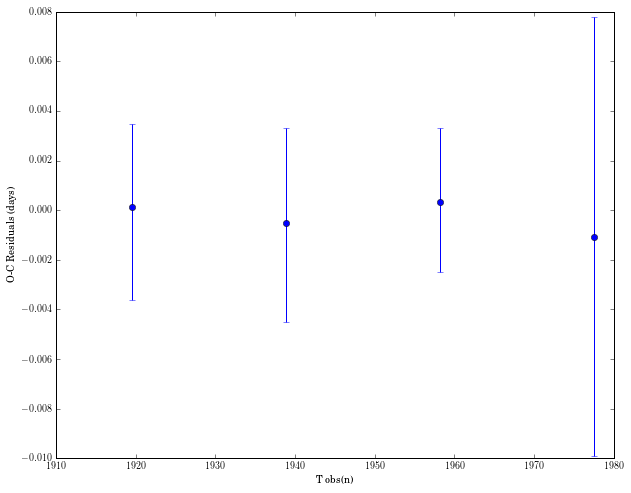

In [58]:
k = np.polyfit(n, tobs, 1)
slopeP = k[0]
t0Final = k[1]

def func(x, a, b): 
    return (a*x + b)

tobserr = np.array(tobsErr) # Convert list to array
popt, pcov = op.curve_fit(func, n, tobs, p0 = [slopeP,t0Final], sigma = tobserr)

'''
popt: Optimal values for the parameters so that the sum of the squared error of "f(xdata, *popt) - ydata" is
    minimized. (Array)
pcov: The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute
    one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)). (2D Array)
'''

perr = np.sqrt(np.diag(pcov))
print "Optimal parameters:", popt
print "Uncertainties of parameters:", perr

t_y = np.array(tobs) - popt[1] - popt[0]*np.array(n)

upper_error = t0fit_mcmc[:,1]
lower_error = t0fit_mcmc[:,2]

asymmetric_error = [lower_error, upper_error]
plt.figure(8)
plt.errorbar(tobs, t_y, yerr=asymmetric_error, fmt='o')
plt.xlabel('T obs(n)')
plt.ylabel('O-C Residuals (days)') #Residuals t obs(n) - t0 - P*n'
plt.show()

In [59]:
np.savetxt('PartII_finalp0t0.txt', popt, fmt='%1.3f', delimiter='   ') 